# Decision trees and NN tryouts on SPR data

In [ ]:
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

In [ ]:
import os
import numpy as np
import pandas as pd

import logging
logging.getLogger().handlers = []
logging.basicConfig(level=logging.INFO)

import matplotlib.pylab as plt
%matplotlib inline

In [ ]:
import sys
sys.path.append("../common")

from dataset2 import load_trainval
from dataset2 import FEATURES_NAMES, TARGET_GROUP_DEC_LABELS, FREQ_TARGET_LABELS, ADDED_TARGET_LABELS, LAST_TARGET_LABELS
from dataset2 import PROCESSED_TARGETS, TARGET_GROUPS_DEC, TARGET_GROUPS, DIFF_TARGETS
from utils import to_yearmonth, TARGET_LABELS, TARGET_LABELS2
from utils import target_str_to_labels, decimal_to_dummies, targets_str_to_indices, targets_dec_to_indices

In [4]:
X, Y = load_trainval(201605, 500000)

INFO:root:- Load file : ../data/train_ver2.csv, yearmonth=201605, n_clients=500000
INFO:root:-- Select 500000 clients
INFO:root:- Number of lines with unknown data : 0
INFO:root:- Number of columns with nan : 10
INFO:root:- Add a supplementary data : 201603
INFO:root:-- Select max clients
INFO:root:- Number of lines with unknown data : 0
INFO:root:- Number of columns with nan : 10
INFO:root:-- Compute missing clients : 2446/500000
INFO:root:--- Setup them with zero targets
INFO:root:- Add a supplementary data : 201601
INFO:root:-- Select max clients
INFO:root:- Number of lines with unknown data : 0
INFO:root:- Number of columns with nan : 10
INFO:root:-- Compute missing clients : 8482/500000
INFO:root:--- Setup them with zero targets
INFO:root:- Add a supplementary data : 201505
INFO:root:-- Select max clients
INFO:root:- Number of lines with unknown data : 3597
INFO:root:- Number of columns with nan : 10
INFO:root:-- Compute missing clients : 164916/500000
INFO:root:--- Setup them wit

In [5]:
print X.shape, Y.shape

(500000, 157) (500000, 76)


In [6]:
set(X.columns) - \
set(FEATURES_NAMES + 
    PROCESSED_TARGETS(1) + 
    PROCESSED_TARGETS(2) + 
    PROCESSED_TARGETS(3) + 
    PROCESSED_TARGETS(4) + 
    DIFF_TARGETS(1, 2) + 
    DIFF_TARGETS(1, 3) + 
    DIFF_TARGETS(1, 4) 
   )

{'fecha_alta', 'fecha_dato', 'ncodpers'}

In [7]:
set(Y.columns) - set(TARGET_LABELS + LAST_TARGET_LABELS.tolist() + ADDED_TARGET_LABELS.tolist())

{'added_targets_dec', 'added_targets_str', 'last_targets_str', 'targets_str'}

In [8]:
X.isnull().any().all(), Y.isnull().any().all()

(False, False)

In [9]:
DIFF_TARGETS(1, 2)

['diff_targets_dec_12',
 'diff_targets_dec_g0_12',
 'diff_targets_dec_g1_12',
 'diff_targets_dec_g2_12',
 'diff_targets_dec_g3_12']

In [10]:
Y['added_targets_dec'].unique()

array([1, 0, 2, 3, 4, 5])

In [15]:
FEATURES_NAMES

[u'ind_empleado',
 u'pais_residencia',
 u'sexo',
 u'age',
 u'ind_nuevo',
 u'antiguedad',
 u'indrel',
 u'ult_fec_cli_1t',
 u'indrel_1mes',
 u'tiprel_1mes',
 u'indresi',
 u'indext',
 u'conyuemp',
 u'canal_entrada',
 u'indfall',
 u'nomprov',
 u'ind_actividad_cliente',
 u'renta',
 u'segmento']

In [12]:
X[['ncodpers', 'targets_str_1', 'targets_str_2', 'diff_targets_dec_12', 'targets_logdec_1', 'targets_logdec_2']].head(10)

,ncodpers,targets_str_1,targets_str_2,diff_targets_dec_12,targets_logdec_1,targets_logdec_2
310487,15889,001000001000000000010000,001000001000000000110000,-32,14.571603,14.571618
310486,15890,000010001000100100100111,000010001000100100100111,0,13.234620,13.234620
310484,15893,000000000000000000010000,000000000000000000010000,0,2.833213,2.833213
310482,15895,001000000000100101110001,001000000000100101110001,0,14.557243,14.557243
310480,15897,000010010000110101110011,000010010000110101110011,0,13.293402,13.293402
310479,15898,000000000000000000000000,000000000000000000000000,0,0.000000,0.000000
310477,15900,000010010000000001000001,000010010000000001000001,0,13.287691,13.287691
310488,15901,001000001000110000110001,001000001000110000110001,0,14.573060,14.573060
310474,15903,001000010000000000100000,001000010000000000100000,0,14.586878,14.586878
310473,15906,000010011001000000000011,000010011001000000000011,0,13.348210,13.348210


In [13]:
mask = Y['added_targets_dec'] > 0
X[mask][['ncodpers', 'fecha_dato', 'targets_str_1', 'targets_str_2', 'targets_str_3', 'targets_str_4'] + DIFF_TARGETS(1, 2) + DIFF_TARGETS(1, 3)].head(10)

,ncodpers,fecha_dato,targets_str_1,targets_str_2,targets_str_3,targets_str_4,diff_targets_dec_12,diff_targets_dec_g0_12,diff_targets_dec_g1_12,diff_targets_dec_g2_12,diff_targets_dec_g3_12,diff_targets_dec_13,diff_targets_dec_g0_13,diff_targets_dec_g1_13,diff_targets_dec_g2_13,diff_targets_dec_g3_13
310487,15889,2016-05-28,001000001000000000010000,001000001000000000110000,001000001000000000110000,001000001000000000110000,-32,-8,0,0,0,-32,-8,0,0,0
310509,15929,2016-05-28,001000001000100000110000,001000001000100000110001,001000001000100000110001,001000001000100000110001,-1,-1,0,0,0,-1,-1,0,0,0
310460,15952,2016-05-28,001000000000000001000000,001000000000000001000001,001000000001000001000001,001000000001000001000001,-1,-1,0,0,0,-4097,-1,-8,0,0
310459,15988,2016-05-28,001000000000000000000000,001000000000000000000000,001000000000000000100000,001000000000000000100000,0,0,0,0,0,-32,-8,0,0,0
310550,16202,2016-05-28,001010000000010001000111,001010000000010001000111,001010000000000001000111,001010000000000001000111,0,0,0,0,0,1024,0,4,0,0
310240,16242,2016-05-28,000000001000000000000001,000000001000000000000001,000000001000000000000001,000010001000000000000001,0,0,0,0,0,0,0,0,0,0
310235,16294,2016-05-28,000010000000000000000111,000010000000000000000111,000010000000001000000111,000010000000001000000111,0,0,0,0,0,-512,0,0,-4,0
310212,16506,2016-05-28,000010000000001001000001,000010000000001001000111,000010000000001001000111,000010000000001001000111,-6,-6,0,0,0,-6,-6,0,0,0
310368,16525,2016-05-28,001010000000110100100111,001010000000110100100111,001010001000110100100111,001010000000110100100111,0,0,0,0,0,-32768,0,-16,0,0
310360,16536,2016-05-28,001000000000000000000011,001000000000000000000000,000000000000000000000000,000000000000000000000000,3,3,0,0,0,2097155,67,0,0,0


In [14]:
X[['ncodpers', 'fecha_dato', 'diff_targets_dec_12', 'diff_targets_dec_g0_12', 'diff_targets_dec_g0_13', 'diff_targets_dec_g0_14']].head(7)

,ncodpers,fecha_dato,diff_targets_dec_12,diff_targets_dec_g0_12,diff_targets_dec_g0_13,diff_targets_dec_g0_14
310487,15889,2016-05-28,-32,-8,-8,-8
310486,15890,2016-05-28,0,0,0,0
310484,15893,2016-05-28,0,0,0,0
310482,15895,2016-05-28,0,0,0,-32
310480,15897,2016-05-28,0,0,-62,-62
310479,15898,2016-05-28,0,0,0,0
310477,15900,2016-05-28,0,0,0,0


### Train a model

In [16]:
from utils import get_added_products, remove_last_choice, apk, map7_score
from visualization import visualize_train_test, visualize_folds, compare_two_datasets, compare_folds, compare_folds2

## Another train/predict + CV implementation

### Input

- `X` : `[nb_samples, nb_features]` shaped pd.DataFrame
    - `features_masks_list` : `{fm1_name: features_mask_1, fm2_name: features_mask_2, ...]` with `features_mask_i` is a list of feature column names. They can oversect.
    
- `Y` : `[nb_samples, nb_labels]` shaped pd.DataFrame
    - `labels_masks_list` : `{lm1_name: labels_mask_1, lm2_name: labels_mask_2, ...}` with `labels_mask_i` is a list of labels column names. They can oversect.

- `samples_masks_list` : `[samples_mask_1, samples_mask_2, ...]` with samples_mask_i is a function to produce a boolean pd.DataFrame . Used only for training. 


- Set of models `models` : list of functions to create a model, e.g. `[create_RF, create_NN, create_GBT]`


### Training phase




In [17]:
from collections import defaultdict
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier

In [18]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Merge
from keras.utils import np_utils

from keras.wrappers.scikit_learn import KerasClassifier

Using Theano backend.


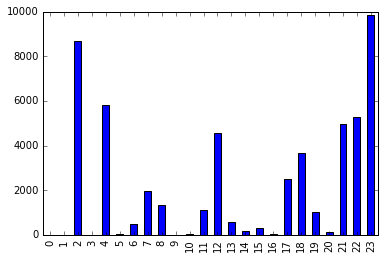

In [19]:
mask = Y['added_targets_dec'] > 0
targets_index_counts = np.zeros((len(TARGET_LABELS)))
for i, c in enumerate(TARGET_LABELS):
    s = (Y[mask][c] > 0).sum()
    targets_index_counts[i] = s

targets_index_counts = pd.Series(targets_index_counts)
targets_index_counts.plot.bar()

In [ ]:
X.columns

In [20]:
samples_masks_list = [
#     lambda x, y:  ~(x['targets_diff'].isin([0])) | ~(y['targets_diff'].isin([0])), 
#     lambda x, y:  (x['targets_diff'] > 0) | (y['targets_diff'] > 0), 
    lambda x, y:  (y['added_targets_dec'] > 0), 
]

features_masks_dict = {
#     'fm_all': FEATURES_NAMES  + 
#                 PROCESSED_TARGETS(1) + 
#                 PROCESSED_TARGETS(2) + 
#                 PROCESSED_TARGETS(3) + 
#                 PROCESSED_TARGETS(4) + 
#                 DIFF_TARGETS(1, 2) + 
#                 DIFF_TARGETS(1, 3) + 
#                 DIFF_TARGETS(1, 4),
    
#     'fm0': FEATURES_NAMES, 
#     'fm1': ['pais_residencia', 'sexo', 'age', 'ind_nuevo', 'segmento', 'ind_empleado', 'ind_actividad_cliente', 'indresi'] + 
#             PROCESSED_TARGETS(4),
#     'fm2': PROCESSED_TARGETS(1) + PROCESSED_TARGETS(4) + DIFF_TARGETS(1, 4),
#     'fm3': ['pais_residencia', 'sexo', 'age', 'segmento', 'renta'],
#     'fm4': FEATURES_NAMES + PROCESSED_TARGETS(1) + PROCESSED_TARGETS(2) + DIFF_TARGETS(1, 2) + PROCESSED_TARGETS(4) + DIFF_TARGETS(1, 4),
#     'fm41': FEATURES_NAMES + PROCESSED_TARGETS(1) + PROCESSED_TARGETS(3) + PROCESSED_TARGETS(4) + DIFF_TARGETS(1, 2) + DIFF_TARGETS(1, 3) + DIFF_TARGETS(1, 4),
    'fm42': FEATURES_NAMES + PROCESSED_TARGETS(1) + PROCESSED_TARGETS(3) + PROCESSED_TARGETS(4) + DIFF_TARGETS(1, 3) + DIFF_TARGETS(1, 4),
    
#     'fm43': ['pais_residencia', 'sexo', 'age', 'ind_nuevo', 'segmento', 'ind_empleado', 'ind_actividad_cliente', 'indresi'] + 
#             PROCESSED_TARGETS(1) + PROCESSED_TARGETS(2) + PROCESSED_TARGETS(4) + DIFF_TARGETS(1, 2) + DIFF_TARGETS(1, 3) + DIFF_TARGETS(1, 4),
#     'fm5': ['nomprov', 'ind_nuevo', 'renta', 'ind_actividad_cliente', 'canal_entrada'] + 
#             PROCESSED_TARGETS(1) + 
#             PROCESSED_TARGETS(4),
#     'fm6': FEATURES_NAMES + PROCESSED_TARGETS(1) + 
#             PROCESSED_TARGETS(2) + 
#             PROCESSED_TARGETS(3) + 
#             PROCESSED_TARGETS(4) + 
#             DIFF_TARGETS(1, 2) + 
#             DIFF_TARGETS(1, 3) + 
#             DIFF_TARGETS(1, 4),
}

In [21]:
# https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/

def create_RF(input_shape, output_shape):        
    # https://www.analyticsvidhya.com/blog/2015/06/tuning-random-forest-model/
    return RandomForestClassifier(n_estimators=100, 
#                                   min_samples_split=100,
#                                   min_samples_leaf=25,
#                                   max_depth=10
                                  max_features=1.0, 
#                                   oob_score=True,
#                                   bootstrap=True,
                                  n_jobs=-1
                                 )

def create_ET(input_shape, output_shape):
    return ExtraTreesClassifier(n_estimators=100,
#                                   min_samples_leaf=25,
#                                   max_depth=10
                                  max_features=1.0, 
#                                   oob_score=True,
#                                   bootstrap=True,
                                  n_jobs=-1

                               )

def create_GB(input_shape, output_shape):
    return GradientBoostingClassifier(n_estimators=100)


def create_NN0(input_shape, output_shape):
        
    assert len(input_shape) == 2, "Input shape should be 2D"
    assert len(output_shape) == 2, "Input shape should be 2D"
    n_features = input_shape[1]
    output_dim = output_shape[1]
    
    print "Create NN0 : ", input_shape, output_shape
    
    def create_model(input_dim=n_features, output_dim=output_dim):
        model = Sequential()
        model.add(Dense(30, init='uniform', input_shape=(input_dim,), activation='relu'))
        model.add(Dropout(0.15))
        model.add(Dense(output_dim, activation='sigmoid'))
#         model.add(Dense(output_dim, activation='softmax'))
#         model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])
        model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])
        return model

    return KerasClassifier(build_fn=create_model, nb_epoch=200, batch_size=2000, verbose=0)
    

models_dict = {
    'rf': create_RF,
    'et': create_ET,
    'gb': create_GB,
#     'nn0': create_NN0
}

In [22]:
np.array(TARGET_GROUPS[0]) + 10

array([12, 14, 22, 28, 31, 32, 33])

In [50]:
NP_TARGET_LABELS = np.array(TARGET_LABELS)
# target_labels = NP_TARGET_LABELS
target_labels = ADDED_TARGET_LABELS
# target_labels = np.array(TARGET_LABELS + ADDED_TARGET_LABELS.tolist())


common_groups = [
#     [2, 4, 7, 8, 11, 12, 13, 15, 17, 18, 19, 21, 22, 23],
#     [2, 4],    
#     [2, 6, 7, 8],
#     [2, 18, 23, 12], 
#     [21, 22],
#     [2, 12, 18],
#     [2, 12, 23],
#     [2, 18, 23],
#     [18, 23, 21, 22],
#     [21, 23, 22, 4],
#     [3, 4], 
#     [22, 7, 8, 23],
#     [0, 1, 14, 15, 17]    
#     [2, 4, 21, 22],
#     [12, 18, 23],
]

common_groups += TARGET_GROUPS
# common_groups += [np.array(g) + len(TARGET_LABELS) for g in TARGET_GROUPS]

# common_groups += [[i] for i in [2, 4, 7, 8, 11, 12, 13, 15, 17, 18, 19, 21, 22, 23]]
common_groups += [[i] for i in [5, 6, 15, 20]]
# common_groups += [[i + len(TARGET_LABELS)] for i in [5, 6, 14, 15, 20]]
# common_groups += [[i] for i in [0, 1, 3, 9, 16]]



def flatten(array):
    out = []
    for item in array:
        out += item
    return out

# others = list(set(range(24)) - set(flatten(common_groups)))

# for i, a in enumerate(zip(TARGET_LABELS2, TARGET_LABELS)):
#     print i, a
    
s = set({})
labels_masks_dict = {}
for i, g in enumerate(common_groups):
    print 'lm_%i' % i, " <=> ", g, "<==>", TARGET_LABELS2[g]
    labels_masks_dict['lm_%i' % i] = target_labels[g]
    s |= set(g)
    
# print 'lm_others', "<=>", others, "<==>", TARGET_LABELS2[others]
# labels_masks_dict['lm_others'] = target_labels[others]
# s |= set(others)

# assert len(s) == len(target_labels), "Sum is not equal 24, s=%i" % s
print labels_masks_dict

lm_0  <=>  [2, 4, 12, 18, 21, 22, 23] <==> ['Current Accounts' 'Payroll Account' 'e-account' 'Credit Card' 'Payroll'
 'Pensions' 'Direct Debit']
lm_1  <=>  [7, 8, 11, 13, 17, 19] <==> ['particular Account' 'particular Plus Account' 'Long-term deposits'
 'Funds' 'Taxes' 'Securities']
lm_2  <=>  [5, 6, 14, 15, 20] <==> ['Junior Account' 'Mas particular Account' 'Mortgage' 'Pensions (plan fin)'
 'Home Account']
lm_3  <=>  [0, 1, 3, 9, 16] <==> ['Saving Account' 'Guarantees' 'Derivada Account' 'Short-term deposits'
 'Loans']
lm_4  <=>  [5] <==> ['Junior Account']
lm_5  <=>  [6] <==> ['Mas particular Account']
lm_6  <=>  [15] <==> ['Pensions (plan fin)']
lm_7  <=>  [20] <==> ['Home Account']
{'lm_0': array(['added_ind_cco_fin_ult1', 'added_ind_cno_fin_ult1',
       'added_ind_ecue_fin_ult1', 'added_ind_tjcr_fin_ult1',
       'added_ind_nomina_ult1', 'added_ind_nom_pens_ult1',
       'added_ind_recibo_ult1'], 
      dtype='|S23'), 'lm_1': array(['added_ind_ctop_fin_ult1', 'added_ind_ctpp_fin

In [51]:
# {model_name: [(samples_mask_code, features_mask_name, labels_mask_name), ...]}
models_pipelines = {
    'gb' : [(None, None, key) for key in labels_masks_dict if len(labels_masks_dict[key]) == 1],    
    'rf' : [(None, None, key) for key in labels_masks_dict if len(labels_masks_dict[key]) > 1],
    'et' : [(None, None, key) for key in labels_masks_dict if len(labels_masks_dict[key]) > 1],
    'nn0' : [(None, None, key) for key in labels_masks_dict if len(labels_masks_dict[key]) > 1],
}
models_pipelines

{'et': [(None, None, 'lm_0'),
  (None, None, 'lm_1'),
  (None, None, 'lm_2'),
  (None, None, 'lm_3')],
 'gb': [(None, None, 'lm_4'),
  (None, None, 'lm_5'),
  (None, None, 'lm_6'),
  (None, None, 'lm_7')],
 'nn0': [(None, None, 'lm_0'),
  (None, None, 'lm_1'),
  (None, None, 'lm_2'),
  (None, None, 'lm_3')],
 'rf': [(None, None, 'lm_0'),
  (None, None, 'lm_1'),
  (None, None, 'lm_2'),
  (None, None, 'lm_3')]}

In [52]:
from trainval import train_all, predict_all, probas_to_indices, score_estimators
from utils import map7_score0

In [53]:
ll = 500000
# ll = 1100

mask = (X.index.isin((X.index[:ll//3]))) | (X.index.isin((X.index[2*ll//3:])))

X1 = X[mask]
Y1 = Y[mask]
print X1.shape, Y1.shape

mask = X.index.isin(X.index[ll//3:2*ll//3])
X2 = X[mask]
Y2 = Y[mask]
print X2.shape, Y2.shape

(333333, 157) (333333, 76)
(166667, 157) (166667, 76)


In [54]:
# res = Y1[labels_masks_dict['lm_0']].apply(dummies_to_decimal, axis=1)
# res = pd.get_dummies(res)
# res.head()

In [55]:
from utils import dummies_to_decimal
from sklearn.preprocessing import StandardScaler


def prepare_to_fit(X_train, Y_train):    
    x_train = X_train.values
    x_train = StandardScaler().fit_transform(x_train)
    y_train = Y_train.apply(dummies_to_decimal, axis=1)
    y_train = pd.get_dummies(y_train)
    y_train = y_train.values    
    return x_train, y_train


def prepare_to_test(X_val, Y_val=None):
    x_val = X_val.values
    x_val = StandardScaler().fit_transform(x_val)
    if Y_val is not None:
        y_val = Y_val.apply(dummies_to_decimal, axis=1)
        y_val = pd.get_dummies(y_val)
        y_val = y_val.values 
    else:
        y_val = None
    return x_val, y_val


def probas_to_labels_probas(y_probas, class_indices, labels):
    l = len(labels)
    out = np.zeros((len(y_probas), l))
    i = 0
    for probas in y_probas:
        if np.sum(probas) > 0:
            pr = np.zeros((l,))
            for index, p in zip(class_indices, probas):
                dummies_str = decimal_to_dummies(index, l)
                pr += p * np.array([float(v) for v in dummies_str])
            out[i, :] = pr    
        i += 1
    return out
    

In [56]:
_kwargs = {
    'samples_masks_list': samples_masks_list, 
    'features_masks_dict': features_masks_dict, 
    'labels_masks_dict': labels_masks_dict, 
    'models_dict': models_dict,
    'labels': target_labels,
    'transform_proba_func': probas_to_indices,
#     'prepare_to_fit_func': prepare_to_fit,
#     'prepare_to_test_func': prepare_to_test,   
#     'probas_to_labels_probas_func': probas_to_labels_probas,
    'threshold': 0.45,
    'n_highest': 7,
    'mode': 'sum',
    'verbose': False,
    'models_pipelines': models_pipelines,
    'return_probas': True
}

In [57]:
estimators = train_all(X1, Y1, **_kwargs)

#print estimators

INFO:root:-- Train all --
INFO:root:-- Process : sample_mask=11448/333333, features_mask=fm42, labels_mask=lm_0
INFO:root:--- Score : model='et', fit accuracy : 0.991527
INFO:root:-- Process : sample_mask=11448/333333, features_mask=fm42, labels_mask=lm_0
INFO:root:--- Score : model='rf', fit accuracy : 0.992750
INFO:root:-- Process : sample_mask=11448/333333, features_mask=fm42, labels_mask=lm_1
INFO:root:--- Score : model='et', fit accuracy : 0.999651
INFO:root:-- Process : sample_mask=11448/333333, features_mask=fm42, labels_mask=lm_1
INFO:root:--- Score : model='rf', fit accuracy : 0.999563
INFO:root:-- Process : sample_mask=11448/333333, features_mask=fm42, labels_mask=lm_2
INFO:root:--- Score : model='et', fit accuracy : 0.996593
INFO:root:-- Process : sample_mask=11448/333333, features_mask=fm42, labels_mask=lm_2
INFO:root:--- Score : model='rf', fit accuracy : 0.996506
INFO:root:-- Process : sample_mask=11448/333333, features_mask=fm42, labels_mask=lm_3
INFO:root:--- Score : mo

In [58]:
accuracies = defaultdict(list)
for e in estimators:
    accuracies[e[0][2]].append(e[2])

mean_accuracy = {}
for key in accuracies:
    accuracy_list = accuracies[key]
    mean_accuracy[key] = sum(accuracy_list)/len(accuracy_list)
    
mean_accuracy

{'et': 0.99694269741439556,
 'gb': 0.9949117749825297,
 'rf': 0.99720475192173308}

In [59]:
_ = score_estimators(estimators, X2, Y2, **_kwargs)

INFO:root:-- Score : model=et, features_mask=fm42, labels_mask=lm_0 -> 0.903028193944
INFO:root:-- Score : model=rf, features_mask=fm42, labels_mask=lm_0 -> 0.592990814018
INFO:root:-- Score : model=et, features_mask=fm42, labels_mask=lm_1 -> 0.997174005652
INFO:root:-- Score : model=rf, features_mask=fm42, labels_mask=lm_1 -> 0.9845500309
INFO:root:-- Score : model=et, features_mask=fm42, labels_mask=lm_2 -> 0.999718000564
INFO:root:-- Score : model=rf, features_mask=fm42, labels_mask=lm_2 -> 0.990856018288
INFO:root:-- Score : model=et, features_mask=fm42, labels_mask=lm_3 -> 0.999952000096
INFO:root:-- Score : model=rf, features_mask=fm42, labels_mask=lm_3 -> 0.999934000132
INFO:root:-- Score : model=gb, features_mask=fm42, labels_mask=lm_4 -> 0.999976000048
INFO:root:-- Score : model=gb, features_mask=fm42, labels_mask=lm_5 -> 0.998938002124
INFO:root:-- Score : model=gb, features_mask=fm42, labels_mask=lm_6 -> 0.999436001128
INFO:root:-- Score : model=gb, features_mask=fm42, label

In [60]:
# logging.getLogger().setLevel(logging.DEBUG)
y_preds, Y_probas = predict_all(estimators, X2, **_kwargs)
#print y_preds[:5]
# logging.getLogger().setLevel(logging.INFO)

INFO:root:-- Predict all --


In [61]:
print y_preds[:5]
Y_probas.head()

[[23] [2] [2] [] []]


,added_ind_ahor_fin_ult1,added_ind_aval_fin_ult1,added_ind_cco_fin_ult1,added_ind_cder_fin_ult1,added_ind_cno_fin_ult1,added_ind_ctju_fin_ult1,added_ind_ctma_fin_ult1,added_ind_ctop_fin_ult1,added_ind_ctpp_fin_ult1,added_ind_deco_fin_ult1,...,added_ind_hip_fin_ult1,added_ind_plan_fin_ult1,added_ind_pres_fin_ult1,added_ind_reca_fin_ult1,added_ind_tjcr_fin_ult1,added_ind_valo_fin_ult1,added_ind_viv_fin_ult1,added_ind_nomina_ult1,added_ind_nom_pens_ult1,added_ind_recibo_ult1
6289,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6285,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6284,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6283,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6282,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [62]:
#labels_masks_dict['lm_0'], common_groups[0]

In [66]:
y_val = targets_str_to_indices(Y2[target_labels].values)
# y_val = targets_str_to_indices(Y2[labels_masks_dict['lm_0']].values, index_map=common_groups[0])
print y_val[:100]
print y_preds[:100]

[[] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] []
 [] [] [] [] [] [] [] [] [] [] [] [] [23] [] [] [] [] [] [] [] [] [] [] []
 [] [] [] [] [] [] [4] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] []
 [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] [] []
 [] []]
[[23] [2] [2] [] [] [] [] [2] [2] [] [] [] [] [2] [19, 17] [] [] [] [23] []
 [2] [] [2] [18] [] [23] [] [] [2] [2] [23] [2] [2] [] [] [] [2] [23] []
 [2] [] [2] [2] [23] [2] [2] [] [] [23] [18] [2] [23] [23] [] [18] [4, 12]
 [] [23] [] [] [] [] [] [2] [] [23] [] [] [21] [] [2] [] [2] [2] [23] [] []
 [2] [] [] [] [] [18] [2] [] [21, 22] [2] [23] [2] [] [19, 17] [2] [23]
 [21, 22] [12] [] [2] [] [] []]


In [67]:
#np.unique(y_preds)

In [68]:
logging.info("- Compute max map7 score")
map7_score(y_val, y_val, Y2[LAST_TARGET_LABELS].values)
logging.info("- Compute map7 score")
map7_score(y_val, y_preds, Y2[LAST_TARGET_LABELS].values)

INFO:root:- Compute max map7 score
INFO:root:-- Predicted map7 score: 0.0216179567641
INFO:root:- Compute map7 score
INFO:root:-- Predicted map7 score: 0.0122781754436


0.012278175443649106


250k
ALL PRODUCTS

FEATURES_NAMES + PROCESSED_TARGETS(1) + PROCESSED_TARGETS(2) + DIFF_TARGETS(1, 2) + PROCESSED_TARGETS(4) + DIFF_TARGETS(1, 4),

INFO:root:- Compute max map7 score
INFO:root:-- Predicted map7 score: 0.0216120864483
INFO:root:- Compute map7 score
INFO:root:-- Predicted map7 score: 0.0163852322076



100k
ALL PRODUCTS

FEATURES_NAMES + PROCESSED_TARGETS(1) + PROCESSED_TARGETS(2) + DIFF_TARGETS(1, 2) + PROCESSED_TARGETS(4) + DIFF_TARGETS(1, 4),
INFO:root:- Compute max map7 score
INFO:root:-- Predicted map7 score: 0.0208802088021
INFO:root:- Compute map7 score
INFO:root:-- Predicted map7 score: 0.0156818234849



ADDED PRODUCTS

PROCESSED_TARGETS(1) + 
PROCESSED_TARGETS(2) + 
PROCESSED_TARGETS(3) + 
PROCESSED_TARGETS(4) + 
DIFF_TARGETS(1, 2) + 
DIFF_TARGETS(1, 3) + 
DIFF_TARGETS(1, 4),
INFO:root:- Compute max map7 score
INFO:root:-- Predicted map7 score: 0.0208802088021
INFO:root:- Compute map7 score
INFO:root:-- Predicted map7 score: 0.0136126361264




FEATURES_NAMES + PROCESSED_TARGETS(1) + PROCESSED_TARGETS(2) + DIFF_TARGETS(1, 2) + PROCESSED_TARGETS(4) + DIFF_TARGETS(1, 4),
INFO:root:- Compute max map7 score
INFO:root:-- Predicted map7 score: 0.0208802088021
INFO:root:- Compute map7 score
INFO:root:-- Predicted map7 score: 0.0138176381764


PROCESSED_TARGETS(1) + PROCESSED_TARGETS(4) + DIFF_TARGETS(1, 4),
INFO:root:- Compute max map7 score
INFO:root:-- Predicted map7 score: 0.0208802088021
INFO:root:- Compute map7 score
INFO:root:-- Predicted map7 score: 0.0136501365014


features + last year
INFO:root:- Compute max map7 score
INFO:root:-- Predicted map7 score: 0.0208802088021
INFO:root:- Compute map7 score
INFO:root:-- Predicted map7 score: 0.00430504305043



features only : 
INFO:root:- Compute max map7 score
INFO:root:-- Predicted map7 score: 0.0208802088021
INFO:root:- Compute map7 score
INFO:root:-- Predicted map7 score: 0.00160001600016




INFO:root:- Compute max map7 score
INFO:root:-- Predicted map7 score: 0.0208802088021
INFO:root:- Compute map7 score
INFO:root:-- Predicted map7 score: 0.016747834145


In [ ]:
# print labels_masks_dict[estimators[0][0][1]]
# print estimators[0][1].classes_
# print estimators[0][1].n_classes_
# print estimators[0][1].n_features_
# print estimators[0][1].n_outputs_
# print estimators[0][1].estimators_

In [69]:
from utils import targets_to_labels, targets_indices_to_labels, remove_last_choice

In [70]:
limit = 25
count = 0

not_predicted_predicted = defaultdict(int)
for last_choice, targets, products, proba in zip(Y2[LAST_TARGET_LABELS].values, y_val, y_preds, Y_probas.values):
    added_products = remove_last_choice(targets, last_choice)
    predictions = remove_last_choice(products, last_choice)
#     print "---", count, last_choice
#     print targets, '->', added_products
#     print products, '->', predictions
#     if count == 3:
#         break
    
    if len(added_products) == 0:
        continue
        
    if len(set(added_products) & set(predictions)) > 0:
#         print "Predicted : ", added_products, predictions
#         print set(added_products) & set(predictions)
        continue

    count += 1
    if count < limit:
        print "--- Count = ", count
        print targets_indices_to_labels(added_products, TARGET_LABELS2)#, targets_indices_to_labels(targets, TARGET_LABELS2)
        print targets_indices_to_labels(predictions, TARGET_LABELS2)#, targets_indices_to_labels(products, TARGET_LABELS2)#, proba
    
    for p in added_products:
        not_predicted_predicted[TARGET_LABELS2[p]] += 1
    

--- Count =  1
['e-account']
[]
--- Count =  2
['particular Account']
[]
--- Count =  3
['Payroll', 'Pensions']
[]
--- Count =  4
['Payroll', 'Pensions']
[]
--- Count =  5
['e-account']
[]
--- Count =  6
['Credit Card']
['Direct Debit']
--- Count =  7
['Direct Debit']
['Securities', 'Taxes', 'Payroll Account']
--- Count =  8
['Direct Debit']
[]
--- Count =  9
['particular Plus Account']
[]
--- Count =  10
['Payroll', 'Pensions']
[]
--- Count =  11
['Payroll', 'Pensions']
[]
--- Count =  12
['Current Accounts']
['e-account']
--- Count =  13
['Payroll Account', 'Payroll', 'Pensions']
['Direct Debit']
--- Count =  14
['particular Plus Account']
['Credit Card']
--- Count =  15
['Direct Debit']
[]
--- Count =  16
['Current Accounts']
['e-account']
--- Count =  17
['Current Accounts', 'Taxes']
['e-account']
--- Count =  18
['Payroll Account', 'Payroll', 'Pensions']
['e-account']
--- Count =  19
['Direct Debit']
[]
--- Count =  20
['e-account']
['Payroll', 'Pensions']
--- Count =  21
['e-acco

In [71]:
print not_predicted_predicted, y_val.shape[0]

defaultdict(<type 'int'>, {'Securities': 11, 'Direct Debit': 343, 'particular Account': 7, 'particular Plus Account': 19, 'e-account': 199, 'Payroll': 318, 'Pensions': 345, 'Taxes': 32, 'Payroll Account': 142, 'Long-term deposits': 8, 'Mas particular Account': 23, 'Funds': 7, 'Credit Card': 232, 'Current Accounts': 193, 'Loans': 1, 'Junior Account': 4, 'Pensions (plan fin)': 3}) 166667


In [ ]:
#print y_probas[:10, target_groups[0]]
#print Y[np.array(TARGET_LABELS)[target_groups[0]]].head(10)

### Run KFold Cross-validation 

In [72]:
from trainval import cross_val_score0, cross_val_score

In [73]:
# Unitary run
nb_folds = 3
results = cross_val_score((X, Y, Y[LAST_TARGET_LABELS].values), nb_folds=nb_folds, **_kwargs)

print "Cross-Validation \n %i | %f | %f | %f | %f | %.5f " % (nb_folds, results.min(), results.mean(), np.median(results), results.max(), results.std())


INFO:root:- Cross validation : 
INFO:root:

		-- Fold : 1 / 3

INFO:root:-- Train all --
INFO:root:-- Process : sample_mask=9143/333333, features_mask=fm42, labels_mask=lm_0
INFO:root:--- Score : model='et', fit accuracy : 0.989391
INFO:root:-- Process : sample_mask=9143/333333, features_mask=fm42, labels_mask=lm_0
INFO:root:--- Score : model='rf', fit accuracy : 0.991031
INFO:root:-- Process : sample_mask=9143/333333, features_mask=fm42, labels_mask=lm_1
INFO:root:--- Score : model='et', fit accuracy : 0.999672
INFO:root:-- Process : sample_mask=9143/333333, features_mask=fm42, labels_mask=lm_1
INFO:root:--- Score : model='rf', fit accuracy : 0.999672
INFO:root:-- Process : sample_mask=9143/333333, features_mask=fm42, labels_mask=lm_2
INFO:root:--- Score : model='et', fit accuracy : 0.995844
INFO:root:-- Process : sample_mask=9143/333333, features_mask=fm42, labels_mask=lm_2
INFO:root:--- Score : model='rf', fit accuracy : 0.995734
INFO:root:-- Process : sample_mask=9143/333333, featu

ValueError: BinomialDeviance requires 2 classes.


### 201505 -> 201605 


gb only
Cross-Validation 
 3 | 0.016073 | 0.019272 | 0.016320 | 0.025423 | 0.00435 


rf + et + gb
Cross-Validation 
 3 | 0.016979 | 0.022598 | 0.024123 | 0.026691 | 0.00411 


Cross-Validation 
 5 | 0.014585 | 0.018385 | 0.019147 | 0.022227 | 0.00294 

Compute cross-validation across several months

## Train model for predictions

In [74]:
estimators = train_all(X, Y, **_kwargs)

INFO:root:-- Train all --
INFO:root:-- Process : sample_mask=15051/500000, features_mask=fm42, labels_mask=lm_0
INFO:root:--- Score : model='et', fit accuracy : 0.993157
INFO:root:-- Process : sample_mask=15051/500000, features_mask=fm42, labels_mask=lm_0
INFO:root:--- Score : model='rf', fit accuracy : 0.994153
INFO:root:-- Process : sample_mask=15051/500000, features_mask=fm42, labels_mask=lm_1
INFO:root:--- Score : model='et', fit accuracy : 0.999734
INFO:root:-- Process : sample_mask=15051/500000, features_mask=fm42, labels_mask=lm_1
INFO:root:--- Score : model='rf', fit accuracy : 0.999535
INFO:root:-- Process : sample_mask=15051/500000, features_mask=fm42, labels_mask=lm_2
INFO:root:--- Score : model='et', fit accuracy : 0.997342
INFO:root:-- Process : sample_mask=15051/500000, features_mask=fm42, labels_mask=lm_2
INFO:root:--- Score : model='rf', fit accuracy : 0.997276
INFO:root:-- Process : sample_mask=15051/500000, features_mask=fm42, labels_mask=lm_3
INFO:root:--- Score : mo

In [ ]:
y_preds, Y_probas = predict_all(estimators, X, **_kwargs)

Check score on the data 2016/05

In [ ]:
y_val = targets_str_to_indices(Y[target_labels].values)
logging.info("- Compute map7 score")
print map7_score(y_val, y_preds, Y[LAST_TARGET_LABELS].values)
logging.info("- Compute max map7 score")
print map7_score(y_val, y_val, Y[LAST_TARGET_LABELS].values)

## Prediction for 2016/06

In [75]:
from dataset2 import load_test

In [76]:
# del X, Y 
# del X1, Y1, X2, Y2
# del Y_probas, y_val, y_preds

In [77]:
X_test, Y_test = load_test()

INFO:root:- Found already generated file, load it
/usr/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2809: DtypeWarning: Columns (112,147) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [78]:
print X_test.shape, Y_test.shape

(929615, 157) (929615, 25)


In [79]:
X_test.head(10)

,ncodpers,fecha_dato,fecha_alta,ind_empleado,pais_residencia,sexo,age,ind_nuevo,antiguedad,indrel,...,diff_targets_dec_13,diff_targets_dec_g0_13,diff_targets_dec_g1_13,diff_targets_dec_g2_13,diff_targets_dec_g3_13,diff_targets_dec_14,diff_targets_dec_g0_14,diff_targets_dec_g1_14,diff_targets_dec_g2_14,diff_targets_dec_g3_14
0,15889,2016-06-28,1995-01-16,2,0,1,9,0,257,1,...,0,0,0,0,0,0,0,0,0,0
1,15890,2016-06-28,1995-01-16,1,0,1,11,0,257,1,...,0,0,0,0,0,0,0,0,0,0
2,15892,2016-06-28,1995-01-16,2,0,0,11,0,257,1,...,0,0,0,0,0,0,0,0,0,0
3,15893,2016-06-28,1997-10-03,0,0,1,11,0,224,1,...,0,0,0,0,0,0,0,0,0,0
4,15894,2016-06-28,1995-01-16,1,0,1,11,0,257,1,...,0,0,0,0,0,0,0,0,0,0
5,15895,2016-06-28,1995-01-16,1,0,0,8,0,257,1,...,0,0,0,0,0,-4096,0,-8,0,0
6,15896,2016-06-28,1995-01-16,2,0,1,8,0,257,1,...,2064,16,1,0,0,67600,16,33,0,0
7,15897,2016-06-28,1995-01-16,1,0,1,11,0,257,1,...,-2097150,-62,0,0,0,-2097152,-64,0,0,0
8,15898,2016-06-28,2000-01-26,0,0,0,11,0,197,1,...,0,0,0,0,0,0,0,0,0,0
9,15899,2016-06-28,1995-01-16,3,0,1,10,0,257,1,...,0,0,0,0,0,0,0,0,0,0


In [80]:
Y_test[LAST_TARGET_LABELS].head(10)

,last_ind_ahor_fin_ult1,last_ind_aval_fin_ult1,last_ind_cco_fin_ult1,last_ind_cder_fin_ult1,last_ind_cno_fin_ult1,last_ind_ctju_fin_ult1,last_ind_ctma_fin_ult1,last_ind_ctop_fin_ult1,last_ind_ctpp_fin_ult1,last_ind_deco_fin_ult1,...,last_ind_hip_fin_ult1,last_ind_plan_fin_ult1,last_ind_pres_fin_ult1,last_ind_reca_fin_ult1,last_ind_tjcr_fin_ult1,last_ind_valo_fin_ult1,last_ind_viv_fin_ult1,last_ind_nomina_ult1,last_ind_nom_pens_ult1,last_ind_recibo_ult1
0,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,1,1,0,0,0,0
1,0,0,0,0,1,0,0,0,1,0,...,0,1,0,0,1,0,0,1,1,1
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,1,1,1,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,1,1,1,0,1,1,1
5,0,0,1,0,0,0,0,0,0,0,...,0,1,0,1,1,1,0,0,0,1
6,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
7,0,0,0,0,1,0,0,1,0,0,...,0,1,0,1,1,1,0,0,1,1
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,1,0,0,0,0,1,1,0,...,0,1,0,0,0,1,0,0,0,1


In [81]:
def get_submission(predicted_added_products, clients, clc, target_labels):
    added_products_col = []
    count = 0 
    for products, last_choice in zip(predicted_added_products, clc):
        predictions = remove_last_choice(products, last_choice)
        added_products_col.append(' '.join([target_labels[i] for i in predictions]))
        count+=1
        if count % 100000 == 0:
            logging.info("Elapsed : %i", count)
            
    out = pd.DataFrame(data={'ncodpers': clients, 'added_products': added_products_col}, columns=['ncodpers', 'added_products'])
    return out

In [82]:
y_test_preds, Y_test_probas = predict_all(estimators, X_test, **_kwargs)

logging.info("- Get submission dataframe:")
clients = X_test['ncodpers'].values
#submission = get_submission(y_preds, clients, clients_last_choice[LC_TARGET_LABELS].values, TARGET_LABELS)

INFO:root:-- Predict all --
INFO:root:- Get submission dataframe:


In [83]:
submission = get_submission(y_test_preds, clients, Y_test[LAST_TARGET_LABELS].values, TARGET_LABELS)

INFO:root:Elapsed : 100000
INFO:root:Elapsed : 200000
INFO:root:Elapsed : 300000
INFO:root:Elapsed : 400000
INFO:root:Elapsed : 500000
INFO:root:Elapsed : 600000
INFO:root:Elapsed : 700000
INFO:root:Elapsed : 800000
INFO:root:Elapsed : 900000


In [84]:
print submission.shape
submission.head()

(929615, 2)


,ncodpers,added_products
0,15889,ind_recibo_ult1
1,15890,ind_cco_fin_ult1
2,15892,
3,15893,
4,15894,ind_cno_fin_ult1


In [ ]:
# selected_estimators = []
# for e in estimators:
#     # estimators = [([features_mask_name, labels_mask_name, model_name], estimator_object, accuracy), ...]
#     features_mask_name, labels_mask_name, model_name = e[0]
# #     print features_mask_name, labels_mask_name, model_name
#     if set(features_masks_dict[features_mask_name]).issubset(test_df.columns):
# #         print "Append the estimator"
#         selected_estimators.append(e)

In [ ]:
# submission_clients = set(submission['ncodpers'].unique())
# test_clients = set(test_df['ncodpers'].unique())
# if submission_clients != test_clients:
#     missing_clients = list(test_clients - submission_clients)
#     missing_clients_mask = test_df['ncodpers'].isin(missing_clients)
    
#     X1 = test_df[missing_clients_mask]
        
#     y_preds, Y_probas = predict_all(selected_estimators, X1, **_kwargs)    
#     submission2 = get_submission(y_preds, missing_clients, X1[LC_TARGET_LABELS].values, TARGET_LABELS)
    
# #     submission = pd.concat([submission, submission2])

In [ ]:
# submission2 = get_submission(y_preds, missing_clients, X1[LC_TARGET_LABELS].values, TARGET_LABELS)
#submission = pd.concat([submission, submission2])

In [ ]:
# print submission2.shape
# submission2.head()

Get submission DataFrame and write csv file

In [ ]:
print submission.shape
submission.head()

In [85]:
from datetime import datetime
import csv

logging.info('- Generate submission')
submission_file = '../results/submission_' + \
                  str(datetime.now().strftime("%Y-%m-%d-%H-%M")) + \
                  '.csv'

submission.to_csv(submission_file, index=False, index_label=False)

INFO:root:- Generate submission


In [ ]:
with open(submission_file, 'r') as r:
    print r.readline()
    print r.readline()
    print r.readline()
    print r.readline()
    print r.readline()
    